# Chapter 5 - Monte Carlo Simulations

## Listing 5.1

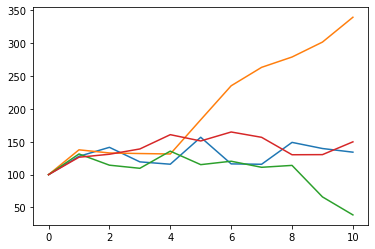

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

np.random.seed(123)

num_years = 10
num_sims = 10000
mean = 8
stdev = 20

z = np.random.normal(loc=mean, scale=stdev, size=(num_sims, num_years+1)) #A

P = np.zeros((num_sims, num_years+1))
P[:,0] = 100 #B

for sim in range(num_sims):
    for year in range(1, num_years+1):
        P[sim, year] = P[sim, year-1] + z[sim, year] #C

plt.plot(P[0:4,:].T);

#A Generate a 2-D array of random price changes for each simulation run and each year
#B Initialize the initial stock prices in each simulation run to 100
#C Add a random price change to last year’s stock price

## Figure 5.2

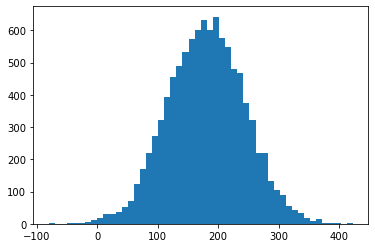

In [6]:
plt.hist(P[:,-1], bins=50);

## Listing 5.2

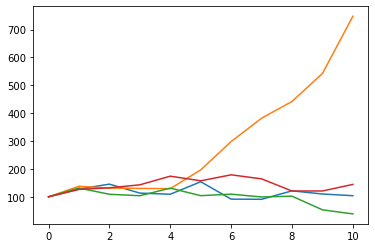

In [7]:
np.random.seed(123)

num_years = 10
num_sims = 10000
mean = 0.08
stdev = 0.20 

ret = np.random.normal(loc=mean, scale=stdev, size=(num_sims, num_years+1)) #A

P = np.zeros((num_sims, num_years+1))
P[:,0] = 100

for sim in range(num_sims):
    for year in range(1, num_years+1):
        P[sim, year] = P[sim, year-1]* (1 + ret[sim, year]) #A

plt.plot(P[0:4,:].T);

#A Generate normal random returns
#B Now we are multiplying last stock price by (1+r)

## Figure 5.4

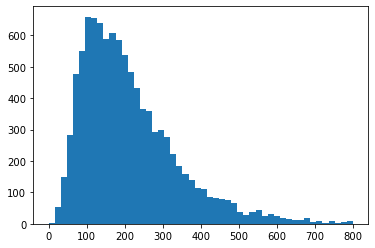

In [9]:
plt.hist(P[:,-1], bins=50, range=(0,800));

## Listing 5.3

In [10]:
import yfinance as yf

SP500 = yf.download('^GSPC', start='1971-12-31', end='2021-12-31') #A
SP500 = SP500.resample('Y').last() #B
SP500['ret'] = SP500['Close'].pct_change() #C 

#A Download S&P daily prices from Yahoo Finance
#B Resample daily data to annual data
#C Compute annual percentage returns from annual prices

[*********************100%***********************]  1 of 1 completed


In [11]:
print('Arithmetic Average: ', SP500['ret'].mean())

Arithmetic Average:  0.09400122842963611


In [12]:
print('Standard Deviation: ', SP500['ret'].std())

Standard Deviation:  0.16725932009600614


In [13]:
print('Geometric Average: ', (SP500['Close'].iloc[-1]/SP500['Close'].iloc[0])**(1/(len(SP500)-1))-1)

Geometric Average:  0.07995730407222146


In [14]:
print('Geometric Average Approximation: ', SP500['ret'].mean() - 0.5 * (SP500['ret'].std())**2)

Geometric Average Approximation:  0.08001338835014699


## Listing 5.4

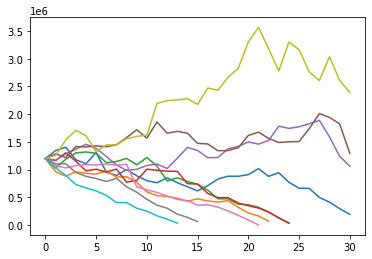

In [16]:
np.random.seed(123)
num_years = 30
num_sims = 10000
mean = 0.06
stdev = 0.12
spending_0 = 60000
W0 = 1200000

inflation = 0.02

ret = np.random.normal(loc=mean, scale=stdev, size=(num_sims, num_years+1))

W = np.empty(shape=[num_sims, num_years+1])
W[:,:] = np.NaN
W[:,0] = W0 #A

count_bankrupt = 0 #B

for sim in range(num_sims):
    spending = spending_0
    for year in range(1, num_years+1):
        # Check whether you run out of money
        next_period_wealth = (W[sim, year-1] - spending) * (1 + ret[sim, year]) #C
        if next_period_wealth < 0:
            count_bankrupt += 1
            break
        else:
            W[sim, year] = next_period_wealth
        spending = spending * (1 + inflation) #D

plt.plot(W[0:10,:].T); #E

#A Every simulation starts with the initial wealth in year 0
#B Keep a running total of how many simulation lead to bankruptcy
#C Spending occurs at the beginning of the period (subtracted before asset growth)
#D Spending increases by the inflation rate every year
#E Plot first 10 sample paths of wealth

In [17]:
print("The probability of bankruptcy is ", count_bankrupt/num_sims)

The probability of bankruptcy is  0.4809


## Listing 5.5

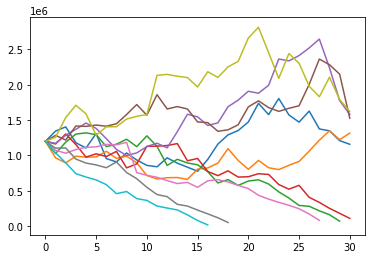

In [18]:
np.random.seed(123)
num_years = 30
num_sims = 10000
mean = 0.06
stdev = 0.12
spending_0 = 60000
spending_min_0 = 48000 #A
W0 = 1200000

inflation = 0.02

ret = np.random.normal(loc=mean, scale=stdev, size=(num_sims, num_years+1))

W = np.empty(shape=[num_sims, num_years+1])
W[:,:] = np.NaN
W[:,0] = W0

count_bankrupt = 0

for sim in range(num_sims):
    spending = spending_0
    spending_min = spending_min_0
    
    for year in range(1, num_years+1):
        next_period_wealth = (W[sim, year-1] - spending) * (1 + ret[sim,year])
        if next_period_wealth < 0: #B
            count_bankrupt += 1
            break
        else:
            W[sim, year] = next_period_wealth 
        spending = spending * (1 + inflation)
        spending_min = spending_min * (1 + inflation) #C
        if (spending < 0.04* W[sim, year]) or (spending > 0.06* W[sim, year]): #D
            spending = max(0.05 * W[sim, year], spending_min) #E

plt.plot(W[0:10,:].T);


#A This is a new constant - the minimum essential spending
#B Check whether you run out of money
#C Minimal essential spending grows with inflation
#D Check whether spending is outside the 4% or 6% guardrails
#E Modify spending if outside guardrails, but not less than the minimum spending required

In [19]:
print("The probability of bankruptcy is ", count_bankrupt/num_sims)

The probability of bankruptcy is  0.2804


## Listing 5.6

In [20]:
import pandas_datareader.data as web #A

start = '01-01-1947'
end = '12-01-2021'
data = web.DataReader(name="CPIAUCNS", data_source='fred', start=start, end=end) #B
data = data.resample('Y').last() #2
data['yoy'] = data['CPIAUCNS'].pct_change() #C
data.tail()

#A Read in monthly levels of CPI from FRED
#B Resample to annual levels of CPI
#C Take percent changes to convert from the index to inflation rate

,CPIAUCNS,yoy
DATE,,
2017-12-31,246.524,0.021091
2018-12-31,251.233,0.019102
2019-12-31,256.974,0.022851
2020-12-31,260.474,0.013620
2021-12-31,278.802,0.070364


## Listing 5.7

In [21]:
import statsmodels.api as sm

data['lag'] = data['yoy'].shift() #A
data = data.dropna() #B
y = data['yoy']
X = data['lag']
X = sm.add_constant(X) #C
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())


#A Shift the original data to create a column of lagged data
#B Drop the first row,b because it contains an #N/A from the shifted data
#C A column of ones has to be added to include a constant in the regression

                            OLS Regression Results                            
Dep. Variable:                    yoy   R-squared:                       0.448
Model:                            OLS   Adj. R-squared:                  0.440
Method:                 Least Squares   F-statistic:                     57.56
Date:                Wed, 13 Sep 2023   Prob (F-statistic):           9.75e-11
Time:                        19:09:45   Log-Likelihood:                 177.32
No. Observations:                  73   AIC:                            -350.6
Df Residuals:                      71   BIC:                            -346.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0115      0.004      2.925      0.0

In [22]:
print(results.resid.std())

0.021471339273482878


## Listing 5.8

In [25]:
np.random.seed(123)
num_years = 30
num_sims = 10000
mean = 0.06
stdev = 0.12
spending_0 = 60000
spending_min_0 = 48000
W0 = 1200000
inf0 = 0.07 #A
phi = 0.6764
c = 0.0115
sigma_inf = 0.0214

ret = np.random.normal(loc=mean, scale=stdev, size=(num_sims, num_years+1))

z_inf = np.random.normal(loc=0, scale=1, size=(num_sims, num_years+1)) #B

inflation = np.zeros(shape=(num_sims, num_years+1))
inflation[:,0] = inf0 #C
for sim in range(num_sims):
    for year in range(1, num_years+1):
        inflation[sim, year] = c + phi*inflation[sim, year-1] + sigma_inf * z_inf[sim, year] #D

W = np.empty(shape=[num_sims, num_years+1])
W[:,:] = np.NaN
W[:,0] = W0

count_bankrupt = 0

for sim in range(num_sims):
    spending = spending_0
    spending_min = spending_min_0

    for year in range(1, num_years+1):
        next_period_wealth = (W[sim, year-1] - spending) * (1 + ret[sim,year])
        if next_period_wealth < 0:
            count_bankrupt += 1
            break
        else:
            W[sim, year] = next_period_wealth 
        spending = spending * (1 + inflation[sim, year]) #E
        spending_min = spending_min * (1 + inflation[sim, year])
        if (spending < 0.04* W[sim, year]) or (spending > 0.06* W[sim, year]):
            spending = max(0.05 * W[sim, year], spending_min)


#A Constants for the AR(1) process for inflation
#B Generate standard normal random numbers used for inflation
#C Initialize inflation for each simulation path
#D Create a matrix of inflation for each year and each simulation according to AR(1) model
#E Now spending grows at a random inflation rate rather than a constant rate

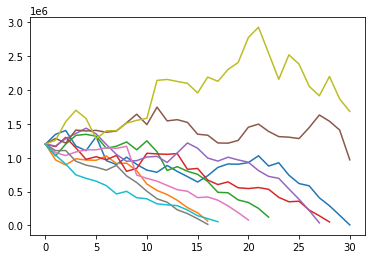

In [24]:
plt.plot(W[0:10,:].T);

## Listing 5.9

In [26]:
from scipy.stats import kurtosis

SP500 = yf.download('^GSPC', start='1971-12-31', end='2021-12-31')
SP500['ret'] = SP500['Close'].pct_change()
SP500 = SP500.dropna()
print(kurtosis(SP500['ret'])) #A


#A The kurtosis function in scipy.stats computes the excess kurtosis of daily returns

[*********************100%***********************]  1 of 1 completed
19.666941859504007


## Listing 5.10

In [32]:
from scipy.stats import gennorm
import math

beta = 1.0 #A
adj_stdev = stdev * (math.gamma(1/beta)/math.gamma(3/beta))**0.5 #B

#ret = np.random.normal(loc=mean, scale=stdev, size=(numb_sims, numb_years+1))
ret = gennorm.rvs(beta, loc=mean, scale=adj_stdev, size=(num_sims, num_years+1)) #C
print('The standard deviation is ', ret.std())


#A The additional GED parameter
#B Adjustment for volatility for Beta
#C Generate GED returns using scipy.stats function gennorm,rvs()

The standard deviation is  20.024897583731704


## Listing 5.11

In [33]:
# Create a time series of annual stock returns
SP500 = yf.download('^GSPC', start='1971-12-31', end='2021-12-31')
SP500 = SP500.resample('Y').last()
SP500['ret'] = SP500['Close'].pct_change()
SP500 = SP500.dropna()

# Generate bootstrapped returns
#ret = np.random.normal(loc=mean, scale=stdev, size=(num_sims, num_years+1))
ret = np.random.choice(SP500['ret'], size=(num_sims, num_years+1)) #A


#A Chooses random returns, with replacement, from S&P500 Series

[*********************100%***********************]  1 of 1 completed


## Listing 5.12

In [34]:
file_name = 'research-2014-rp-mort-tab-rates-exposure.xlsx' #A
sheet = 'White Collar'
gender = 'Males'
if gender == 'Males':
    usecols = 'B,E'
elif gender == 'Females':
    usecols = 'B,I'
mort = pd.read_excel(file_name, sheet, header=3, usecols=usecols).set_index('Age')
mort.dropna(inplace=True)
mort.head()

#A Mortality data file

,Healthy Annuitant
Age,
50,0.002764
51,0.002981
52,0.003202
53,0.003429
54,0.003661


## Listing 5.13

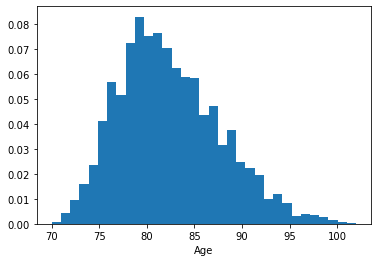

In [37]:
np.random.seed(123)
num_years = 50
num_sims = 10000
mean = 0.06
stdev = 0.12
spending_0 = 60000
W0 = 1200000
age_start = 60 #A

inflation = 0.02

# Generate normal random returns
ret = np.random.normal(loc=mean, scale=stdev, size=(num_sims, num_years+1))

# Initialize Wealth
W = np.empty(shape=[num_sims, num_years+1])
W[:,:] = np.NaN
W[:,0] = W0

# Keep track of age if bankrupt
age_bankruptcy = [] #B

for sim in range(num_sims):
    spending = spending_0
    year = 0
    alive = True
    bankrupt = False
    while not bankrupt and alive: #C
        # Check whether you run out of money
        if W[sim, year] - spending < 0:
            age_bankruptcy.append(year+age_start)
            bankrupt = True
        else:
            # Check whether you live to the next year
            mortality_prob = mort['Healthy Annuitant'].loc[year+age_start] #D
            p = np.random.uniform() #E
            if p < mortality_prob:
                alive = False
            else:
                year += 1
                W[sim,year] = (W[sim, year-1] - spending) * (1 + ret[sim, year])
            spending = spending * (1 + inflation)
    
bins = max(age_bankruptcy) - min(age_bankruptcy) + 1
plt.hist(age_bankruptcy, bins=bins, density=True)
plt.xlabel("Age");

#A The starting age of retiree
#B We will append to this list the age that money runs out
#C The loop ends either when a retiree dies or runs out of money
#D The probability of dying, pulled from the mortality table
#E A uniform (0,1) random number that will be compared to the probability of dying

In [38]:
print('The prob of running out of money is ',len(age_bankruptcy)/num_sims)

The prob of running out of money is  0.3686
